# Stocastic Petri Net Analysis

- Evaluation for a stochastic model described by SPN/GSPN/MRSPN
- The tool `gospn` creates a marking graph (CTMC transition matrices)
- NMarkov uses the CTMC

## Install for gospn

- The repository: [https://github.com/okamumu/gospn](https://github.com/okamumu/gospn)
- Build with Go or download a binary directly from [https://github.com/okamumu/gospn/releases/latest](https://github.com/okamumu/gospn/releases/latest)
- Put the binary `gospn` to the directory

In [ ]:
;wget https://github.com/okamumu/gospn/releases/download/v0.9.2/gospn-0.9.2-linux-amd64.tar.gz

In [2]:
;tar zxvf gospn-0.9.2-linux-amd64.tar.gz

gospn


## Install for NMarkov

Use Pkg to install the packages. The packages are located in GitHub. Please run the following commands:

- For Julia 1.0.5
```julia
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
...
```

In [42]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/NMarkov.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/JuliaDot.jl.git"))

  Updating git-repo `https://github.com/JuliaReliab/Origin.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/JuliaReliab/Deformula.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/JuliaReliab/SparseMatrix.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/JuliaReliab/NMarkov.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/JuliaReliab/JuliaD

In [48]:
# require the following packages.
# Install them with the package mode.

# Pkg.add(MAT)
# Pkg.add(JSON)
# Pkg.add(Plots)
# Pkg.add(SparseArrays)
# Pkg.add(Distributions)

## Initialize

Load packages

In [49]:
using Origin
using SparseMatrix
using NMarkov
using JuliaDot
using SparseArrays
using Plots
using MAT
using JSON
using Distributions

In [4]:
# utility function
function drawfile(x)
    data = open(x) do f
        read(f, String)
    end
    draw(data) # JuliaDot.draw
end

drawfile (generic function with 1 method)

In [5]:
import NMarkov.eye
function eye(M::AbstractMatrix)
    eye(size(M)[1])
end

eye (generic function with 3 methods)

## Example: GSPN

Use the model: IaaS Cloud (monolithic)
```
  R. Ghosh, F. Longo, F. Frattini, S. Russo and K.S. Trivedi,
  Scalable analytics for IaaS cloud availability,
  IEEE Transactions on Cloud Computing, 2:1, 57-70, 2014.
```

### Draw a petrinet

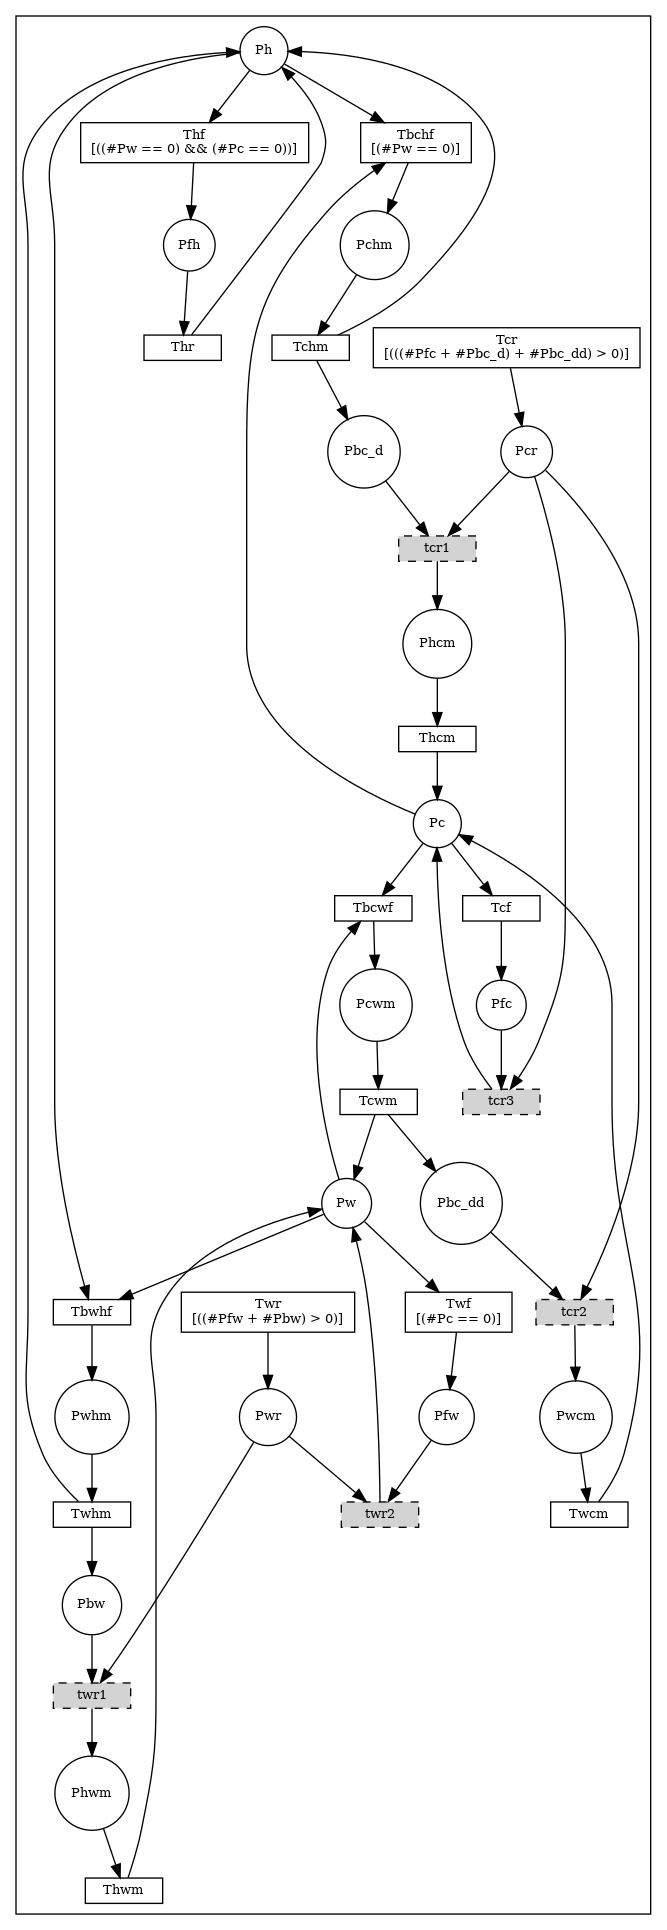

In [6]:
run(`./gospn view -i iaas_cloud.spn -o tmp.dot`)
drawfile("tmp.dot")

### Generate the marking graph

In [99]:
run(`./gospn mark -i iaas_cloud.spn -o result.mat -t -g gmark.dot`)
matfile = matopen("result.mat")

Create marking...done
computation time : 0.4014 (sec)
# of total states         : 14110 (63398)
# of total EXP/GEN states : 10272 (55603)
# of total IMM states     : 3838 (7795)
# of total ABS states     : 0 (0)
(EXP)
  # of EXP/GEN states ( G0) : 10272 (55603)
  # of IMM states     ( I0) : 3838 (7795)

Write transition matrix G0G0E
Write transition matrix G0I0E
Write transition matrix I0G0I
Write init vector initG0
Write init vector initI0
Write reward vector rwd6G0
Write reward vector rwd6I0
Write reward vector rwd1G0
Write reward vector rwd1I0
Write reward vector rwd2G0
Write reward vector rwd2I0
Write reward vector rwd3G0
Write reward vector rwd3I0
Write reward vector avail1G0
Write reward vector avail1I0
Write reward vector avail2G0
Write reward vector avail2I0
Write reward vector avail3I0
Write reward vector avail3G0
Write reward vector rwd5G0
Write reward vector rwd5I0
Write group marking graph...done


MAT.MAT_v5.Matlabv5File(IOStream(<file result.mat>), false, #undef)

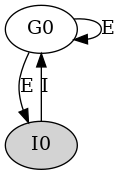

In [100]:
drawfile("gmark.dot")

In the above graph, Gxx indicates EXP/GEN group where there is no enabled IMM transitions. Also Ixx indicates IMM group where there is one or more enabled IMM transitions. From the above graph, we find that there is no self-loop in I0. Then I0 can be vanished by
```
Q = G0G0E + G0I0E * I0G0I
```

In [101]:
# Read matrices
G0G0E = read(matfile, "G0G0E")
G0I0E = read(matfile, "G0I0E")
I0G0I = read(matfile, "I0G0I");

In [102]:
# CTMC transition matrix (IMM group should be vanished)
Q = G0G0E + G0I0E * I0G0I;
println("nnz ", length(Q.nzval) - Q.m)

nnz 59560


In [103]:
# initial probabiliyt vector
x0 = read(matfile, "initG0");

In [104]:
# load reward vector
r1 = read(matfile, "rwd1G0"); #Ph
r2 = read(matfile, "rwd2G0"); #Pw
r3 = read(matfile, "rwd3G0"); #Pc

In [105]:
# expected number of hot/warm/cold servers in steady state
pis, conv, = stgs(Q)
println("Convergence ", conv)
println("# of hot servers ", sum(pis .* r1))
println("# of warm servers ", sum(pis .* r2))
println("# of cold servers ", sum(pis .* r3))

Convergence true
# of hot servers 2.99700299700209
# of warm servers 2.974860950007484
# of cold servers 2.9895493271672775


In [118]:
# Transient
ts = LinRange(0.0, 1000.0, 100)
irwd1, crwd1, xt1, cxt1 = tran(Q, x0, r1, ts, forward=:T);
irwd2, crwd2, xt2, cxt2 = tran(Q, x0, r2, ts, forward=:T);
irwd3, crwd3, xt3, cxt3 = tran(Q, x0, r3, ts, forward=:T);

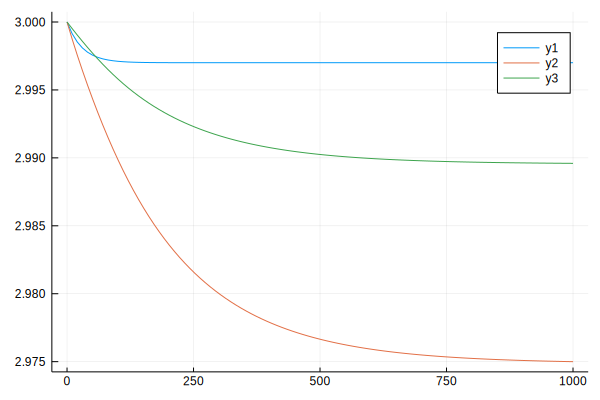

In [119]:
plot(ts, [irwd1, irwd2, irwd3])

In [133]:
println("# of hot servers  (time average) ", sum(cxt1 .* r1)/1000.0)
println("# of warm servers (time average) ", sum(cxt1 .* r2)/1000.0)
println("# of cold servers (time average) ", sum(cxt1 .* r3)/1000.0)

# of hot servers  (time average) 2.9970927984146303
# of warm servers (time average) 2.9796356056398428
# of cold servers (time average) 2.991510485351518


## Example: MRSPN

Use the model: RAID6
```
  F. Machida, R. Xia and K.S. Trivedi,
  Performability modeling for RAID storage systems by Markov regenerative process,
  IEEE Transactions on Dependable and Secure Computing
```

### Draw a Petrinet

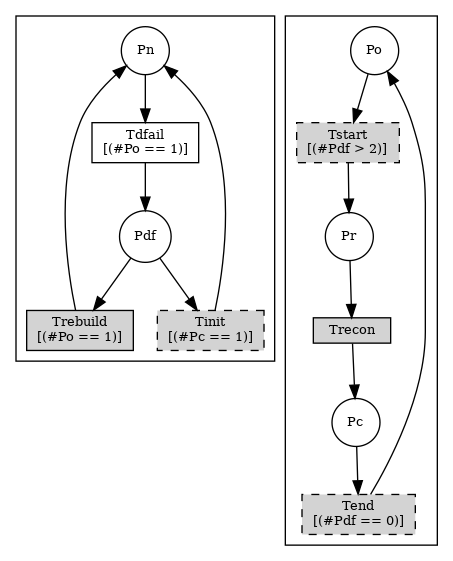

In [21]:
run(`./gospn view -i raid6.spn -o tmp.dot`)
drawfile("tmp.dot")

### Generate the marking graph

In [22]:
run(`./gospn mark -i raid6.spn -o result.mat -t -g gmark.dot`)
matfile = matopen("result.mat")

Create marking...done
computation time : 0.0001 (sec)
# of total states         : 5 (7)
# of total EXP/GEN states : 4 (6)
# of total IMM states     : 1 (1)
# of total ABS states     : 0 (0)
(EXP)
  # of EXP/GEN states ( G0) : 1 (1)
(Trecon->E)
  # of EXP/GEN states ( G1) : 1 (1)
(Trebuild->E)
  # of EXP/GEN states ( G2) : 2 (4)
  # of IMM states     ( I2) : 1 (1)

Write transition matrix G1G1E
Write transition matrix G0G0E
Write transition matrix G0G2E
Write transition matrix G2G2E
Write transition matrix G2I2E
Write transition matrix I2G1I
Write transition matrix G2G0P0
Write transition matrix G2G2P0
Write transition matrix G1G0P1
Write init vector initG0
Write init vector initG2
Write init vector initI2
Write init vector initG1
Write reward vector unavailG1
Write reward vector unavailG0
Write reward vector unavailG2
Write reward vector unavailI2
Write reward vector availG2
Write reward vector availI2
Write reward vector availG1
Write reward vector availG0
Write group marking graph...

MAT.MAT_v5.Matlabv5File(IOStream(<file result.mat>), false, #undef)

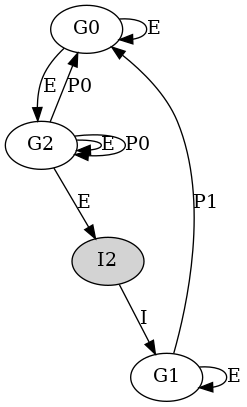

In [23]:
# Draw a group grapah
drawfile("gmark.dot")

This model includes two GEN transitions; Trecon and Trebuild. Thus there are three groups for markings
- G0: There is no enabled GEN transition
- G1: Trecon is enabled (# of states is 1)
- G2: Trebuild is enabled (# of states is 2)
Now we focus on the discrete-time Markov chain at time instants when G1 and G2 enters, so-called embedded Markov chain (EMC). G1 is 

In [28]:
# Read matrices
G0G0E = read(matfile, "G0G0E")
G0G2E = read(matfile, "G0G2E")
G1G1E = read(matfile, "G1G1E")
G1G0P1 = read(matfile, "G1G0P1")
G2G0P0 = read(matfile, "G2G0P0")
G2G2E = read(matfile, "G2G2E")
G2G2P0 = read(matfile, "G2G2P0")
G2I2E = read(matfile, "G2I2E")
I2G1I = read(matfile, "I2G1I");

In [29]:
# parameter for GEN dist
MTTR1 = 2.0 # [hours]
MTTR2 = 24.0; # [hours] reconfigure

In [30]:
# Make EMC

## Matrix on time instant of the end of state
V0 = -G0G0E \ eye(G0G0E)
V1, V1c = mexpc(G1G1E, eye(G1G1E), MTTR2) # constant distribution
V2, V2c = mexpc(G2G2E, eye(G2G2E), MTTR1) # constant distribution

# indicies when all states are concatinated [V0, V1, V2]
indices = [1:1, 2:2, 3:4] 

## Transition probability matrices for EMC.
## This is constucted by the groupmark graph
P = spzeros(AbstractMatrix{Float64}, 3, 3) # blockmatrix
@origin P=>0 begin
    P[0,2] = V0 * G0G2E
    P[1,0] = V1 * G1G0P1
    P[2,0] = V2 * G2G0P0
    P[2,1] = V2 * G2I2E * I2G1I
    P[2,2] = V2 * G2G2P0
end
P=sparse(block(P))

4×4 SparseMatrixCSC{Float64,Int64} with 7 stored entries:
  [2, 1]  =  1.0
  [3, 1]  =  0.999
  [3, 2]  =  3.9964e-7
  [4, 2]  =  0.00039968
  [1, 3]  =  1.0
  [3, 3]  =  0.0009991
  [4, 3]  =  0.9992

In [31]:
# stationary vector for EMC
pid = gth(Matrix(P))

4-element Array{Float64,1}:
 0.4997500001208041 
 1.99919911409815e-7
 0.5002497999592845 
 0.0                

In [32]:
# sojourn time & stationary distribution
S = spzeros(AbstractMatrix{Float64}, 3, 3) # blockmatrix
@origin S=>0 begin
    S[0,0] = V0
    S[1,1] = V1c
    S[2,2] = V2c
end
S=sparse(block(S))
sojourn = S' * pid
pis = sojourn / sum(sojourn)

4-element Array{Float64,1}:
 0.9988002354440062   
 5.75366240182053e-9  
 0.0011991592827204109
 5.99519611064011e-7  

In [34]:
# Read reward
availG0 = read(matfile, "availG0")
availG1 = read(matfile, "availG1")
availG2 = read(matfile, "availG2")
unavailG0 = read(matfile, "unavailG0")
unavailG1 = read(matfile, "unavailG1")
unavailG2 = read(matfile, "unavailG2");

In [36]:
@origin indices=>0 begin
    avail = sum(pis[indices[0]] .* availG0) + sum(pis[indices[1]] .* availG1) + sum(pis[indices[2]] .* availG2)
    unavail = sum(pis[indices[0]] .* unavailG0) + sum(pis[indices[1]] .* unavailG1) + sum(pis[indices[2]] .* unavailG2)
end
MTTDL = avail / unavail * MTTR2 / 24 /365

476170.7970156398

## Example: MC simulation

Use the model: IaaS Cloud (monolithic)
```
  R. Ghosh, F. Longo, F. Frattini, S. Russo and K.S. Trivedi,
  Scalable analytics for IaaS cloud availability,
  IEEE Transactions on Cloud Computing, 2:1, 57-70, 2014.
```

### Draw a petrinet

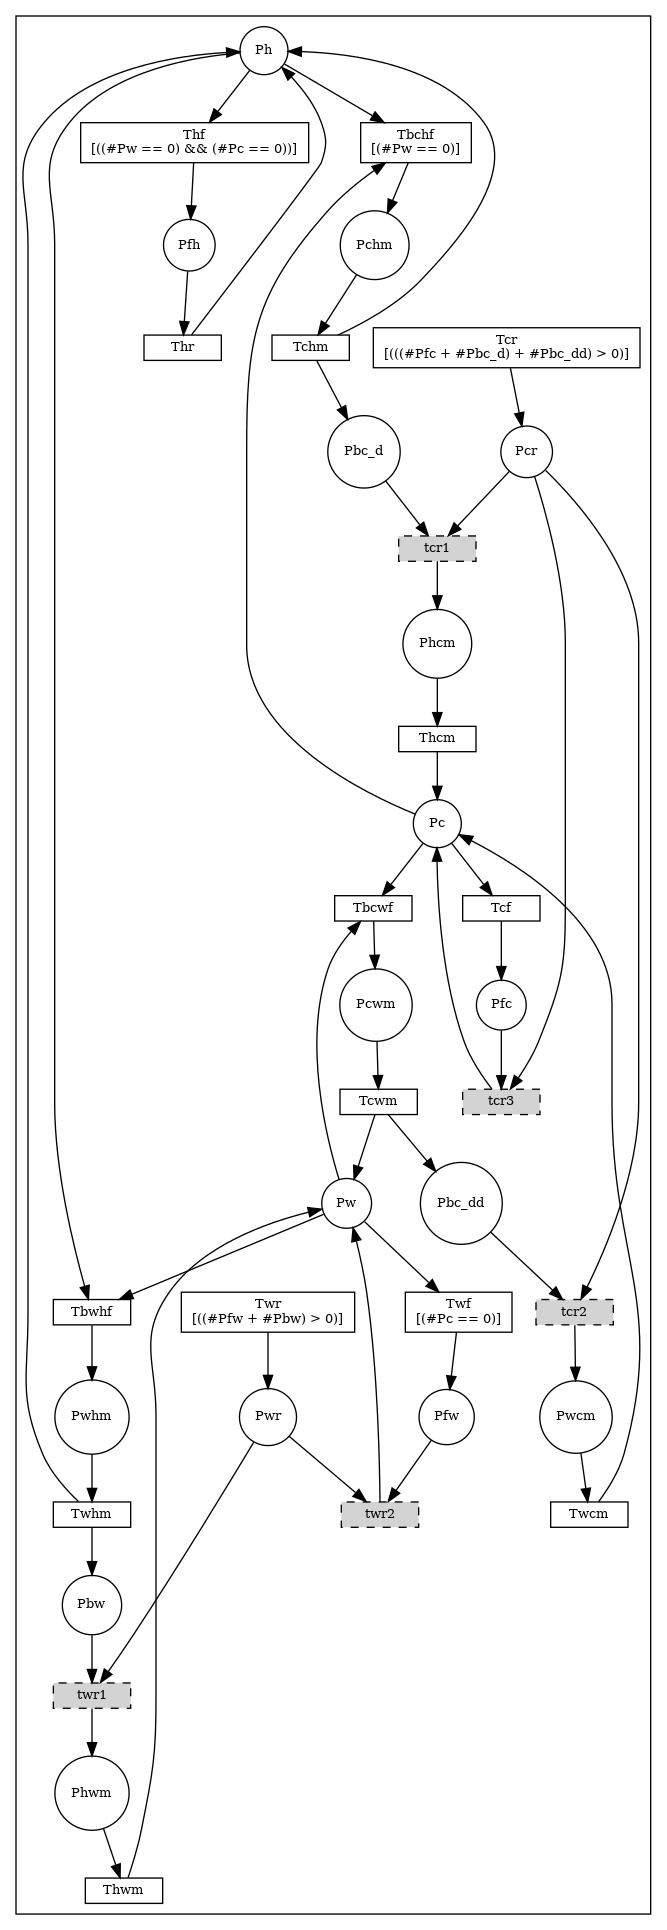

In [37]:
run(`./gospn view -i iaas_cloud.spn -o tmp.dot`)
drawfile("tmp.dot")

In [135]:
## generate config for simulation with JSON
config = Dict(
    "time" => 1000.0,   # the stop condition for one simulation
    "firings" => 0,       # the stop condition for one simulation
    "simulations" => 1000, # the number of simulation runs
    "rewards" => ["rwd1", "rwd2", "rwd3"]
)

open("config.json", "w") do f 
    write(f, JSON.json(config)) 
end;

In [140]:
run(`./gospn sim -i iaas_cloud.spn -o result.mat -f config.json -s 12345`)
matfile = matopen("result.mat")
keys(read(matfile))

Run simulation...done
computation time : 0.0257 (sec)


Base.KeySet for a Dict{String,Any} with 8 entries. Keys:
  "rwd3_irwd"
  "rwd3_crwd"
  "elapsedtime"
  "count"
  "rwd2_irwd"
  "rwd2_crwd"
  "rwd1_irwd"
  "rwd1_crwd"

In [141]:
elapsedtime = read(matfile, "elapsedtime")
rwd1 = read(matfile, "rwd1_crwd") ./ elapsedtime
rwd2 = read(matfile, "rwd2_crwd") ./ elapsedtime
rwd3 = read(matfile, "rwd3_crwd") ./ elapsedtime;

In [142]:
# utility
function meanConfidenceInterval(data, alpha)
    n = length(data)
    m = sum(data) / n
    s = sqrt(sum((data .- m).^2) / (n-1))
    h = quantile(TDist(n-1), 1-(1-alpha)/2) * s / sqrt(n)
    (m, m-h, m+h)
end

meanConfidenceInterval (generic function with 2 methods)

In [143]:
println(meanConfidenceInterval(rwd1, 0.99)) # doubtful?
println(meanConfidenceInterval(rwd2, 0.99))
println(meanConfidenceInterval(rwd3, 0.99))

(2.9553807953007505, 2.941977971390745, 2.968783619210756)
(2.927591704013121, 2.9091020568833565, 2.946081351142886)
(2.975537378185735, 2.965066504619203, 2.9860082517522666)


In [ ]:
# of hot servers  (time average) 2.9970927984146303
# of warm servers (time average) 2.9796356056398428
# of cold servers (time average) 2.991510485351518